# Theory kernel analysis: a quantitative method to evaluate action unit based theories of emotional facial expression perception
*Lukas Snoek, June 2020*

This notebook describes how "theory kernels" can be used to formalize and quantify action-unit based theories. It primarily meant as a demonstration of the method and to showcase some preliminary results.

## Introduction
The face, and dynamic facial expressions, is a powerful and efficient medium to express and transmit internal cognitive and affective states, and has arguably been formally investigated most often in the context of emotion experience and perception. Since the pioneering work by Paul Ekman (ref), researchers have tried to describe and quantify how, on the one hand, affective states generate facial expressions and, on the other hand, how emotions are inferred from facial expressions. Central to this endeavor are "action units" &mdash (groups of) muscles that realize different facial movements. Previous studies have shown that experience of different (categorical) emotions reliably (?) activate specific configurations of action units (ref, ref, ref). Similarly, other studies have shown that specific configurations of action units reliably lead to the perception of different categorical emotions. However, there is no full agreement about the exact mapping between emotion (experience and perception) and action units. Since Ekman, there have been many different "theories" about this mapping. These theories, while often supported by quantitative analyses, are limited in their value as a *model* of emotion perception. In this study, we develop a novel way to quantify such action unit based theories of emotional facial expression perception, which we call "theory kernel analysis".

### Action unit based theories of emotional facial expression perception
Bla bla

### What's in a model?
* A model is quantitative; allows for prediction of new data

### Current study
* reiterate idea in more detail

## Methods
We use data from an existing dataset from Glasgow University which contains 2400 emotion ratings of random facial expressions from 60 subjects. Specifically, each stimulus was endowed with a set of "action units" (AUs), i.e., specific facial movements, ranging in "intensity" from 0.1 to 1), randomly drawn from a full set of 42 action units. Note that these stimuli were generated with a limited set of AUs; specifically, the the number of AUs per stimulus was drawn from a binomial distribution with $n=6$ and $p=0.5$: $N_{\mathrm{AU}} \sim \mathrm{Binom}(6, .5)$.

Now, suppose that we have a particular stimulus, $S_{i}$, which contains AU1, AU2, and AU5 with intensities 0.1, 0.5, and 0.8. For simplicity, assume that these were drawn from a full set of 10 AUs (AU1, AU2, ... , AU10). Then, formally, we can represent this particular stimulus, $S_{i}$, as a point (or vector) in 10-dimensional space:

\begin{align}
S_{i} = 
\begin{bmatrix}
.1, .5, 0, 0, .8, 0, 0, 0, 0, 0
\end{bmatrix}
\end{align}

Let's also define this as an actual vector:

In [2]:
import numpy as np
S_i = np.array([[.1, .5, 0, 0, .8, 0, 0, 0, 0, 0]])

Although AUs are studied in various contexts, they are arguably most often studied in relation to the expression of (one's own) or perception of (others') emotions. Specifically, starting with research by Paul Ekman, AUs have often been used to describe how people express emotions by defining AU *configurations* for different categorical emotions. 

For example, a particular theory, $T$, may propose that (typical) "happiness" is expressed with a AU configuration including AU1 and AU10. Similar to our hypothetical stimulus $S_{i}$, we can represent this theoretical AU configuration as a point in 10-dimensional space:

\begin{align}
T_{\mathrm{happy}} =
\begin{bmatrix}
1, 0, 0, 0, 0, 0, 0, 0, 0, 1
\end{bmatrix}
\end{align}

Again, we can define this as an actual vector:

In [3]:
T_happy = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

Categorical emotion theories often propose configurations for different categorical emotions, such that a theory can be formulated as an $M \times P$ matrix for $M$ categories (here: emotions) coded as across $P$ variables (here: action units). For example, such a matrix may look like the following:

\begin{align}
T = 
\begin{bmatrix}
1, 0, 0, 0, 0, 0, 0, 0, 0, 1 \\
0, 1, 0, 0, 0, 1, 1, 0, 0, 0 \\
0, 1, 1, 0, 0, 0, 0, 1, 0, 0 \\
0, 0, 0, 1, 0, 0, 0, 0, 0, 0 \\
0, 0, 0, 0, 1, 0, 0, 1, 0, 0 \\
1, 1, 0, 0, 0, 1, 0, 0, 0, 1
\end{bmatrix}
\end{align}

where its rows represent the different classes (emotions):

\begin{align}
E = \{\mathrm{Happy}, \mathrm{Angry}, \mathrm{Sad}, \mathrm{Disgust}, \mathrm{Fear}, \mathrm{Surprise}\}
\end{align}

Although the above represents a hypothetical theory, its sparsity is something we would expect, as facial expressions are unlikely to be generated by a full (dense) set of action units. Again, let's implement this construct as a 2D array:

In [4]:
# We use Th instead of T to prevent confusion with the transpose (.T)
Th = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
    [1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
])

In [5]:
S_i 

array([[0.1, 0.5, 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. ]])

In this study, we are interested in whether action unit configurations can predict observers' perception of emotion. Theories, conceptualized as hypothetical sets of action units mapped to emotions, are not *models*, in the sense that they are not quantitative, are not able to make predictions, and are difficult to express in mathetically or in code. Here, we attempt to formalize such action unit based theories by converting them into mathematical, predictive models that are able to quantify and evaluate the hypothesized mapping between action unit configurations and categorical emotions. To do so, we use kernel functions ($k$) to quantify the similarity, $\phi$, between a stimulus with a known action unit configuration ($S_{i}$) and a theoretical action unit configuration for a specific emotion, $j$ ($T_{j}$, e.g., happiness): 

\begin{align}
k(S_{i}, T_{j})
\end{align}

Most (linear) kernel functions are based on the dot (inner) product of the theory vector ($T_{j}$) and the stimulus vector ($S_{i}$). In fact, a "linear kernel" is just this:

\begin{align}
k(S_{i}, T_{j}) = S_{i}T^{T}
\end{align}

but more complicated kernels exist (like the "sigmoid kernel": $\tanh(\gamma S_{i}^{T}T_{j} + c_{0}$)).

To generate a prediction for stimulus $S_{i}$ (i.e., $\hat{y}_{i}$), one can pick the emotion ($j = 1 \dots M$) that maximizes its similarity, for some kernel function, to the stimulus:

\begin{align}
\hat{y}_{i} = \underset{j}{\operatorname{argmax}}k(S_{i}, T_{j})
\end{align}

Below, this is implemented in code by taking the argmax of the dot product (linear kernel) between the stimulus and the theory array:

In [6]:
y_hat = np.argmax(S_i @ Th.T)

In a slightly more sophisticated version, we can generate *probabilistic* predictions, e.g., $p(E | T, S_{i})$ by normalizing each of the $j = 1 \dots M$ similarities ($\phi_{i,j}$), to the 0-1 range using the softmax function:

\begin{align}
P(E_{j} | T, S_{i}) = \sigma(\phi_{i, j}) = \frac{e^{\beta\phi_{i, j}}}{\sum_{j=1}^{M} e^{\beta\phi_{i, j}}}
\end{align}

where $\beta$ is the "inverse temperature" parameter &mdash; a scaling parameter &mdash; which distributes relatively more mass onto the largest values. In our framework, we can treat this parameter as a model hyperparameter (i.e., a parameter that is not fit, but manually tuned).

In [7]:
def softmax(phi, beta):
    """ Softmax function with inverse temperature (beta) parameters.
    
    Parameters
    ----------
    phi : array
        Similarities for M classes
    beta : int/float
        Inverse temperature parameter
        
    Returns
    -------
    p : array
        Probabilities for M classes
    """
    bphi = beta * phi
    # max value is subtracted to prevent overflow
    p = np.exp(bphi - bphi.max()) / np.sum(np.exp(bphi - bphi.max()))
    return p

p = softmax(S_i @ Th.T, 5)
p

array([[0.01621203, 0.1197916 , 0.1197916 , 0.00983309, 0.53686871,
        0.19750296]])

To evaluate each theory, we can compare their (discrete or probabilistic) predictions with data from participants who actually rated those stimuli in terms of perceived emotion. In other words, we can quantitatively assess how well the theoretical predictions match with actual behavior.

In our analyses, we used the "area under the curve of the receiver operating characteristic" (AUROC) which summarizes the quality of probabilistic predictions in a range from 0 to 1, where 0.5 is chance level and 1 is a perfect prediction.

## 2. Evaluated theories
Many action unit based theories of emotion (perception) have been put forward, but in this study we assessed those summarized in the article by [Barrett and colleagues (2019)](https://journals.sagepub.com/doi/full/10.1177/1529100619832930). Additionally, we included the Ekman configuration (2002; taken from [Clark et al., 2020](https://www.frontiersin.org/articles/10.3389/fpsyg.2020.00920/full), Table 3). So, in total, we evaluated six hypothesized action unit configurations ("theories", for simplicity):

* Darwin
* Matsumoto 2008
* Keltner 2009
* Cordaro 2008 (ref)
* Cordaro 2008 (IPC)
* Ekman (2002)

Each theory contains one or more configurations per emotion. For example, according to Ekman, digust may be communicated (and thus perceived) using a combination of AU09+AU17, AU10+AU17, AU10+AU16+AU25, AU9+AU16+AU26, AU10+AU16+AU26, AU09, or AU10. In our analyses, whenever multiple configurations exist for a given emotion, we use the highest similarity value amongst the different configurations. 

## 3. Results

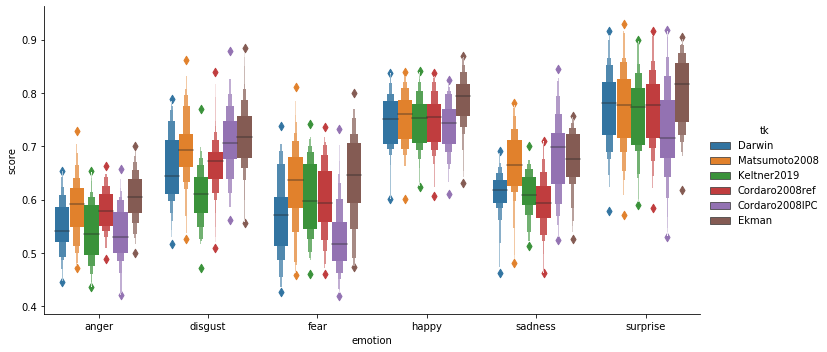

In [8]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('../results/auroc.tsv', sep='\t', index_col=0)
sns.catplot(x='emotion', y='score', hue='tk', data=df, kind='boxen', aspect=2);

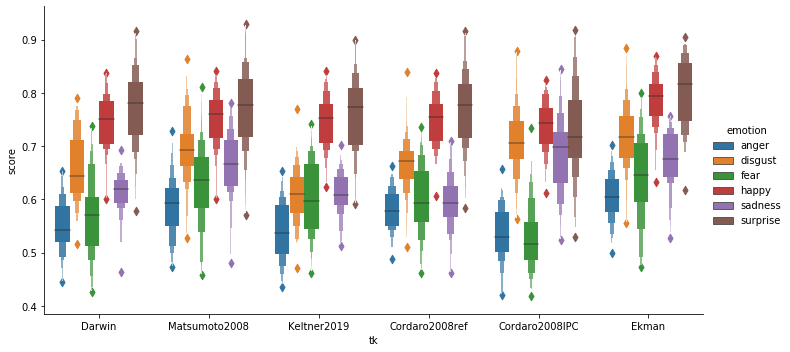

In [9]:
sns.catplot(x='tk', y='score', hue='emotion', data=df, kind='boxen', aspect=2);

In [10]:
preds = pd.read_csv('../results/predictions.tsv', sep='\t', index_col=0)

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm

ohe = OneHotEncoder(sparse=False)
emo = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
ohe.fit(np.array(emo)[:, np.newaxis])

df_int = []
for sub in tqdm(preds['sub'].unique()):
    for tk in preds['tk'].unique():
        intensities = preds.query("sub == @sub")['intensity'].unique()
        scores = np.zeros((5, 6))
        scores[:, :] = np.nan
        for itns in intensities:
            tmp = preds.query("tk == @tk & sub == @sub & intensity == @itns")
            y_ohe = ohe.transform(tmp['y_true'].to_numpy()[:, np.newaxis])
            e_idx = y_ohe.sum(axis=0) != 0
            scores[itns-1, e_idx] = roc_auc_score(y_ohe[:, e_idx], tmp.iloc[:, :6].loc[:, e_idx], average=None)
        
        scores = pd.DataFrame(scores, index=range(1, 6), columns=emo)
        scores['intensity'] = range(1, 6)
        scores = pd.melt(scores, id_vars='intensity', var_name='emotion', value_name='score')
        scores['sub'] = sub
        scores['tk'] = tk
        df_int.append(scores)
        
df_int = pd.concat(df_int)

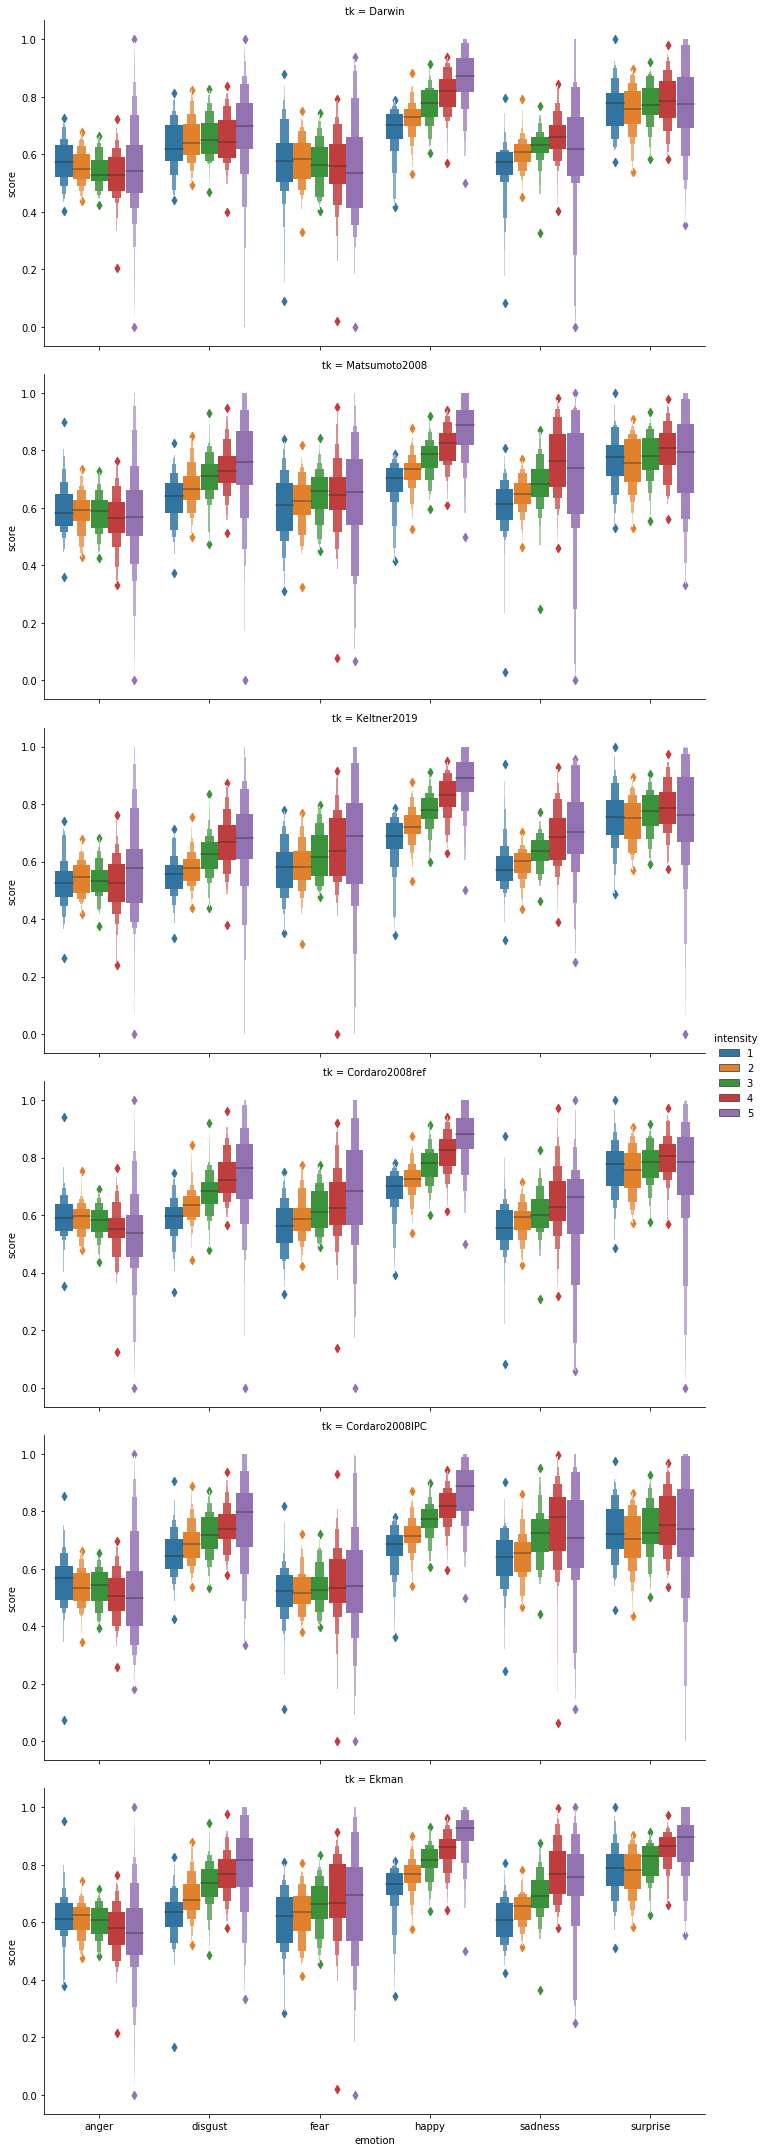

In [12]:
sns.catplot(x='emotion', y='score', hue='intensity', row='tk', data=df_int, kind='boxen', aspect=2);

## 4. Noise ceiling

In [13]:
nc = pd.read_csv('../results/noise_ceilings.tsv', sep='\t', index_col=0)
bs_nc = nc.iloc[-1, :]

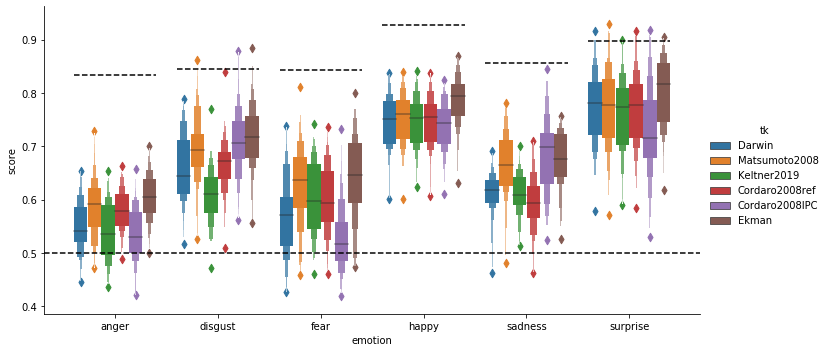

In [18]:
import matplotlib.pyplot as plt

sns.catplot(x='emotion', y='score', hue='tk', data=df, kind='boxen', aspect=2);
for i, this_nc in enumerate(bs_nc):
    plt.plot([i-.4, i+.4], [this_nc, this_nc], c='k', ls='--')
plt.axhline(0.5, ls='--', c='k')

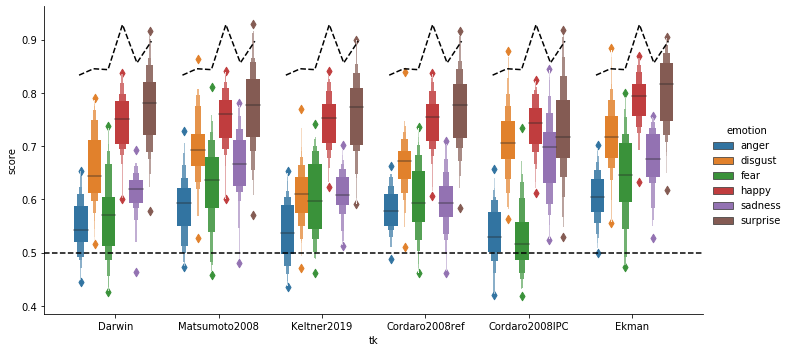

In [16]:
sns.catplot(x='tk', y='score', hue='emotion', data=df, kind='boxen', aspect=2);
for i in range(6):
    plt.plot(np.linspace(i-.35, i+.35, 6), bs_nc, ls='--', c='k')
    
plt.axhline(0.5, ls='--', c='k')

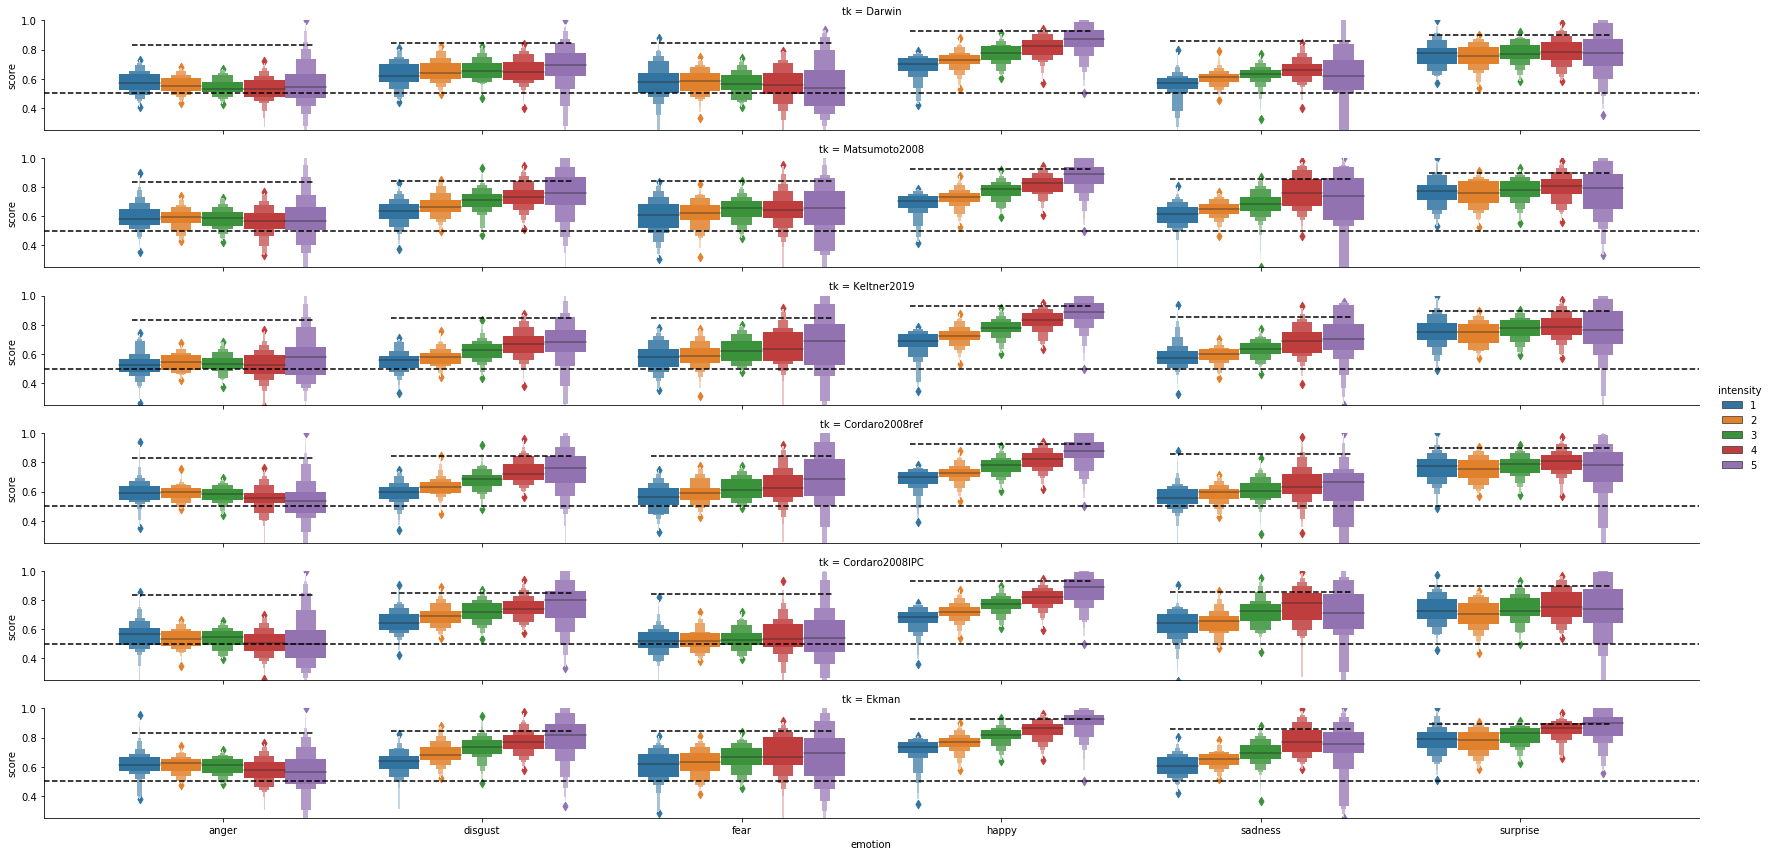

In [47]:
g = sns.catplot(x='emotion', y='score', hue='intensity', row='tk', data=df_int, kind='boxen', aspect=12, height=2);
for ax in g.axes:
    ax[0].set_ylim(0.25, 1)
    ax[0].axhline(0.5, ls='--', c='k')
    for i in range(6):
        ax[0].plot(np.linspace(i-.35, i+.35, 5), [bs_nc[i]] * 5, ls='--', c='k')


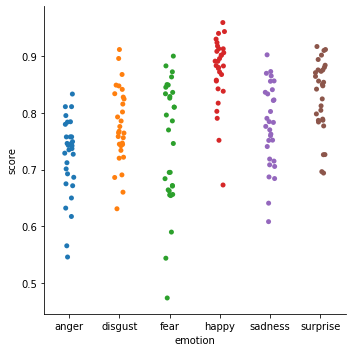

In [8]:
df_ml = pd.read_csv('../results/method-ml_analysis-between_auroc.tsv', sep='\t', index_col=0)
sns.catplot(x='emotion', y='score', data=df_ml)